In [68]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image


In [53]:
train_dir = 'C:/chest_xray/train'
val_dir = 'C:/chest_xray/val'
test_dir = 'C:/chest_xray/test'

In [54]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

In [55]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    color_mode='grayscale',
    batch_size=32,
    image_size=(256, 256)
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    color_mode='grayscale',
    batch_size=32,
    image_size=(256, 256)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    color_mode='grayscale',
    batch_size=32,
    image_size=(256, 256)
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


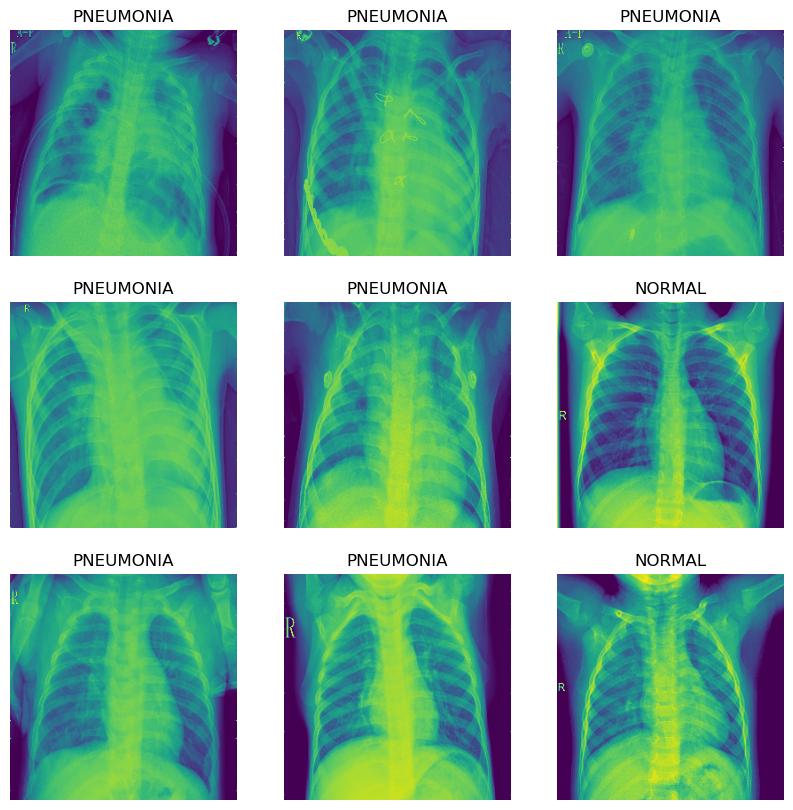

In [56]:

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(np.squeeze(images[i].numpy().astype('uint8')))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis('off')


In [57]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [58]:
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Add dropout with a rate of 0.2 (20% of units will be dropped)
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Add dropout with a rate of 0.2
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Add dropout with a rate of 0.2
    layers.Flatten(),
    layers.Dense(128, activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.01)),
    layers.Dropout(0.2),  # Add dropout with a rate of 0.2
    layers.Dense(2, activation='softmax')
])

In [59]:
model.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [73]:
# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Compile and fit the model with the EarlyStopping callback
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callback =early_stopping_callback
)

TypeError: 'EarlyStopping' object is not callable

In [62]:
test_loss, test_accuracy = model.evaluate(test_ds)

print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))


20/20 [==============================] - 4s 190ms/step - loss: 1.2437 - accuracy: 0.7532
Test Loss: 1.2437
Test Accuracy: 75.32%


In [71]:
# Load and preprocess the image

image = Image.open("C:/chest_xray/test/NORMAL/IM-0011-0001-0001.jpeg").resize((256, 256)).convert('L')
input_image = np.array(image)
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
            
# Make predictions
predictions = model.predict(input_image)
predicted_class_index = np.argmax(predictions)
            
# Get the predicted class label
class_names = ['Normal', 'Pneumonia']  # Replace with your class labels
predicted_class_label = class_names[predicted_class_index]
            
# Return the prediction as a response
print(predicted_class_label)
print(predictions)

1/1 [==============================] - 0s 31ms/step
Pneumonia
[[0.25037295 0.749627  ]]


In [ ]:
import pickle

# Save model weights
model_weights = model.get_weights()
with open('model_weights.pkl', 'wb') as f:
    pickle.dump(model_weights, f)

# Save model architecture
model_architecture = model.to_json()
with open('model_architecture.pkl', 'wb') as f:
    pickle.dump(model_architecture, f)